### RNA folding kinetics control riboswitch sensitivity in vivo 
#### David Z. Bushhouse1,3 , Jiayu Fu1,3, & Julius B. Lucks1,2,3,4,5,6* 

 

1 Interdisciplinary Biological Sciences Graduate Program, Northwestern University, Evanston, Illinois 60208, USA 

2 Department of Chemical and Biological Engineering, Northwestern University, Evanston, Illinois 60208, USA 

3 Center for Synthetic Biology, Northwestern University, Evanston, Illinois 60208, USA 

4 Center for Water Research, Northwestern University, Evanston, Illinois 60208, USA 

5 Center for Engineering Sustainability and Resilience, Northwestern University, Evanston, Illinois 60208, USA 

6 International Institute for Nanotechnology, Northwestern University, Evanston, Illinois 60208, USA 


* To whom correspondence should be addressed. Tel: 1-847-467-2943; Email: jblucks@northwestern.edu  

## Fitting dose reponse data, extracting functional parameters, and plotting functional landscape
This code is part 2 of the FACS-seq analysis pipeline. Ensure that all replicates have been processed in part 1 before proceeding.

#### Install the necessary packages and set up file path

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import shutil
from Bio.SeqIO.QualityIO import FastqGeneralIterator

# Paths to your Multiplied data CSV files
csv_file_path_rep1 = 'PATH-TO-SRA-DEPOSITION/Analysis/MultipliedData_Rep1.csv'
csv_file_path_rep2 = 'PATH-TO-SRA-DEPOSITION/Analysis/MultipliedData_Rep2.csv'
combined_experimental_suffix = 'LoopN7'
combined_data_path = 'PATH-TO-SRA-DEPOSITION'

#### Initial fitting with free n

In [ ]:
# The Hill equation
def hill_eq(x, a, b, n, k):
    return a + ((b * x**n) / (k**n + x**n))

# Loading data from both CSVs
df_rep1 = pd.read_csv(csv_file_path_rep1)
df_rep2 = pd.read_csv(csv_file_path_rep2)

# Merge the two dataframes based on a common identifier (e.g., first column)
merged_df = pd.merge(df_rep1, df_rep2, on=df_rep1.columns[0], how='outer')

# X values for individual replicates
x_values = np.array([1e-5, 0.01, 0.1, 0.32, 1])

# Prepare an empty dataframe to store results
results = pd.DataFrame(columns=['Item', 'a', 'b', 'n', 'k', 'Dynamic Range', 'Min', 'Max', 'Standard Error',
                                'SE_k', 'SE_Dynamic_Range', 'SE_Min', 'SE_Max'])

# Empty list to store 'n' values
n_values = []

# Looping over all rows (processing each one)
for i in range(merged_df.shape[0]):
    print(f"Processing row {i+1}...")

    # Extract y-values for both replicates
    y_values_rep1 = merged_df.iloc[i, 1:6]
    y_values_rep2 = merged_df.iloc[i, 6:11]

    # Combine y-values and corresponding x-values only if they are not NaN
    combined_y_values = []
    combined_x_values = []
    for j in range(len(x_values)):
        if pd.notna(y_values_rep1[j]):
            combined_y_values.append(y_values_rep1[j])
            combined_x_values.append(x_values[j])
        if pd.notna(y_values_rep2[j]):
            combined_y_values.append(y_values_rep2[j])
            combined_x_values.append(x_values[j])

    if len(combined_y_values) < 4:  
        print("TOO LITTLE DATA for row {}".format(i+1))
        new_row = pd.DataFrame({'Item': [merged_df.iloc[i, 0]]})
        results = pd.concat([results, new_row], ignore_index=True)
        continue

    combined_y_values = np.array(combined_y_values)
    combined_x_values = np.array(combined_x_values)

    max_val = np.max(combined_y_values)
    initial_k = 0.25  # Initial guess for k within the bounds
    p0 = [1, max_val - 1, 1.4, initial_k]  # Initial guess for the parameters

    # Bounds for parameters: a, b, n, k (k is bounded between 0 and 0.5)
    bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, 1])

    try:
        popt, pcov = curve_fit(hill_eq, combined_x_values, combined_y_values, p0, bounds=bounds, maxfev=10000)
        n_values.append(popt[2])  # Append 'n' value to the list of 'n' values
        SE_a, SE_b, SE_n, SE_k = np.sqrt(np.diag(pcov))
        y_pred = hill_eq(combined_x_values, *popt)
        se = math.sqrt(mean_squared_error(combined_y_values, y_pred))
        dynamic_range = (popt[0] + popt[1]) / popt[0]
        SE_dynamic_range = dynamic_range * np.sqrt((SE_a/popt[0])**2 + (SE_b/popt[1])**2)
        Min = popt[0]
        Max = popt[0] + popt[1]
        SE_Min = SE_a
        SE_Max = np.sqrt(SE_a**2 + SE_b**2)

        new_row = pd.DataFrame({
            'Item': [merged_df.iloc[i, 0]],
            'a': [popt[0]],
            'b': [popt[1]],
            'n': [popt[2]],
            'k': [popt[3]],
            'Dynamic Range': [dynamic_range],
            'Min': [Min],
            'Max': [Max],
            'Standard Error': [se],
            'SE_k': [SE_k],
            'SE_Dynamic_Range': [SE_dynamic_range],
            'SE_Min': [SE_Min],
            'SE_Max': [SE_Max]
        })
        results = pd.concat([results, new_row], ignore_index=True)

    except RuntimeError:
        print("Curve fitting did not converge for this row.")

# Calculate median of 'n' values
median_n = np.median(n_values)

# Specifically round 'k' and 'SE_k' to 5 decimal places
results['k'] = results['k'].round(5)
results['SE_k'] = results['SE_k'].round(5)

# Round all other numeric columns in the dataframe to 2 decimal places
cols_to_round_2dp = [col for col in results.columns if col not in ['k', 'SE_k', 'Item']]
for col in cols_to_round_2dp:
    results[col] = results[col].round(2)

# Update the path for saving the results
output_filename = os.path.join(combined_data_path, f'Combined_Hill_Fit_Results_{combined_experimental_suffix}.csv')
# Saving the results dataframe to a new CSV file
results.to_csv(output_filename, index=False)

print(f"Median 'n' value: {median_n}")

#### Refitting with fixed n

In [ ]:
# The Hill equation
def hill_eq_fixed_n(x, a, b, k):
    return a + ((b * x**median_n) / (k**median_n + x**median_n))

# Paths to your Multiplied data CSV files
csv_file_path_rep1 = '/Users/davidbushhouse/SRA-Deposition/Analysis/MultipliedData_Rep1.csv'
csv_file_path_rep2 = '/Users/davidbushhouse/SRA-Deposition/Analysis/MultipliedData_Rep2.csv'
combined_experimental_suffix = 'LoopN7'
combined_data_path = '/Users/davidbushhouse/SRA-Deposition'

# Loading data from both CSVs
df_rep1 = pd.read_csv(csv_file_path_rep1)
df_rep2 = pd.read_csv(csv_file_path_rep2)

# Merge the two dataframes based on a common identifier (e.g., first column)
merged_df = pd.merge(df_rep1, df_rep2, on=df_rep1.columns[0], how='outer')

# X values for individual replicates
x_values = np.array([1e-5, 0.01, 0.1, 0.32, 1])

# Prepare an empty dataframe to store results
results = pd.DataFrame(columns=['Item', 'a', 'b', 'n', 'k', 'Dynamic Range', 'Min', 'Max', 'Standard Error',
                                'SE_k', 'SE_Dynamic_Range', 'SE_Min', 'SE_Max'])

# Empty list to store 'n' values
n_values = []

# Looping over all rows (processing each one)
for i in range(merged_df.shape[0]):
    print(f"Processing row {i+1}...")

    # Extract y-values for both replicates
    y_values_rep1 = merged_df.iloc[i, 1:6]
    y_values_rep2 = merged_df.iloc[i, 6:11]

    # Combine y-values and corresponding x-values only if they are not NaN
    combined_y_values = []
    combined_x_values = []
    for j in range(len(x_values)):
        if pd.notna(y_values_rep1[j]):
            combined_y_values.append(y_values_rep1[j])
            combined_x_values.append(x_values[j])
        if pd.notna(y_values_rep2[j]):
            combined_y_values.append(y_values_rep2[j])
            combined_x_values.append(x_values[j])

    if len(combined_y_values) < 4:  
        print("TOO LITTLE DATA for row {}".format(i+1))
        new_row = pd.DataFrame({'Item': [merged_df.iloc[i, 0]]})
        results = pd.concat([results, new_row], ignore_index=True)
        continue

    combined_y_values = np.array(combined_y_values)
    combined_x_values = np.array(combined_x_values)

    max_val = np.max(combined_y_values)
    initial_k = 0.25  # Initial guess for k within the bounds
    p0 = [1, max_val - 1, initial_k]  # Initial guess for the parameters

    # Bounds for parameters: a, b, k (k is bounded between 0 and 0.5)
    bounds = ([0, 0, 0], [np.inf, np.inf, 1])

    try:
        popt, pcov = curve_fit(hill_eq_fixed_n, combined_x_values, combined_y_values, p0, bounds=bounds, maxfev=10000)
        n_values.append(median_n)  # Append 'n' value to the list of 'n' values
        SE_a, SE_b, SE_k = np.sqrt(np.diag(pcov))
        y_pred = hill_eq_fixed_n(combined_x_values, *popt)
        se = math.sqrt(mean_squared_error(combined_y_values, y_pred))
        dynamic_range = (popt[0] + popt[1]) / popt[0]
        SE_dynamic_range = dynamic_range * np.sqrt((SE_a/popt[0])**2 + (SE_b/popt[1])**2)
        Min = popt[0]
        Max = popt[0] + popt[1]
        SE_Min = SE_a
        SE_Max = np.sqrt(SE_a**2 + SE_b**2)

        new_row = pd.DataFrame({
            'Item': [merged_df.iloc[i, 0]],
            'a': [popt[0]],
            'b': [popt[1]],
            'n': [median_n],  # Use median_n as the 'n' value
            'k': [popt[2]],
            'Dynamic Range': [dynamic_range],
            'Min': [Min],
            'Max': [Max],
            'Standard Error': [se],
            'SE_k': [SE_k],
            'SE_Dynamic_Range': [SE_dynamic_range],
            'SE_Min': [SE_Min],
            'SE_Max': [SE_Max]
        })
        results = pd.concat([results, new_row], ignore_index=True)

    except RuntimeError:
        print("Curve fitting did not converge for this row.")


# Specifically round 'k' and 'SE_k' to 5 decimal places
results['k'] = results['k'].round(5)
results['SE_k'] = results['SE_k'].round(5)

# Round all other numeric columns in the dataframe to 2 decimal places
cols_to_round_2dp = [col for col in results.columns if col not in ['k', 'SE_k', 'Item']]
for col in cols_to_round_2dp:
    results[col] = results[col].round(2)

# Update the path for saving the results
output_filename = os.path.join(combined_data_path, f'Combined_Hill_Fit_Results-fixed-n_{combined_experimental_suffix}.csv')
# Saving the results dataframe to a new CSV file
results.to_csv(output_filename, index=False)

#### Data Cleaning:

In [ ]:
results = pd.read_csv(os.path.join(combined_data_path, f'Combined_Hill_Fit_Results-fixed-n_{combined_experimental_suffix}.csv'))

# Remove rows with no data except in the first column ('Item')
results = results.dropna(how='all', subset=results.columns[1:])

# Remove rows where 'k' values are not between 0 and 1
results = results[(results['k'] >= 0) & (results['k'] <= 0.5)]

# Remove rows where 'Dynamic Range' values are not between 0 and 15
results = results[(results['Dynamic Range'] >= 0) & (results['Dynamic Range'] <= 50)]


# Add a new condition to filter rows where SE_k / k is less than or equal to 0.05
# Ensure division by zero is handled
results = results[((results['SE_k'] / results['k']) <= 1)]

results = results[((results['SE_Dynamic_Range'] / results['Dynamic Range']) <= 1)]

# Save the cleaned data, if needed
cleaned_file_path = os.path.join(combined_data_path, f'Cleaned_Combined_Hill_Fit_Results-fixed-n_{combined_experimental_suffix}.csv')
results.to_csv(cleaned_file_path, index=False)



#### Making a Gaussian Kernel Density Plot

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

#### Perform Gaussian KDE

In [4]:
df = pd.read_csv('Cleaned_Combined_Hill_Fit_Results-fixed-n_LoopN7.csv')

x_data = df['Dynamic Range']
y_data = df['k']

# Create a Gaussian KDE using your data
kde = gaussian_kde([x_data, y_data])

# Create a grid of points to evaluate the density
x_grid, y_grid = np.meshgrid(np.linspace(min(x_data), max(x_data), 3289),
                             np.linspace(min(y_data), max(y_data), 3289))
grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the density at each point on the grid
density = kde(grid_points)

# Reshape the density values to match the grid shape
density = density.reshape(x_grid.shape)

# Sort the density values in descending order
sorted_density = -np.sort(-density, axis=None)

# Calculate the cumulative sum of the sorted density values
cumulative_density = np.cumsum(sorted_density)

#### Generating Plot

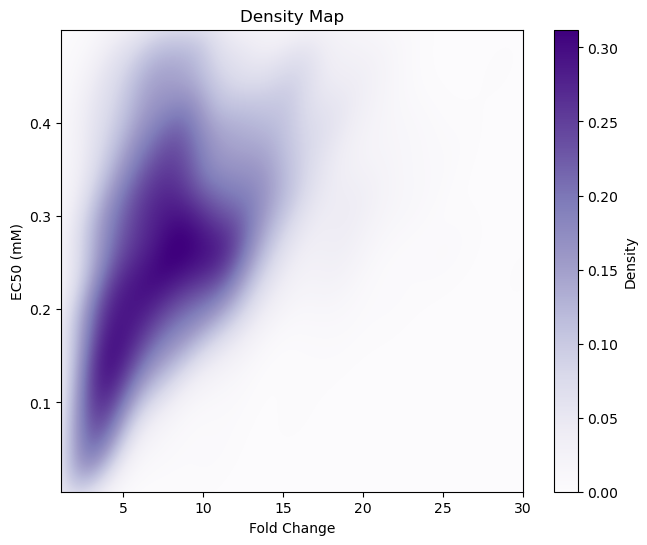

In [5]:
aspect_ratio = (max(x_data) - min(x_data)) / (max(y_data) - min(y_data))

# Create a density plot with adjusted aspect ratio
plt.figure(figsize=(8, 6))
plt.imshow(density, cmap='Purples', origin='lower', extent=[min(x_data), max(x_data), min(y_data), max(y_data)], aspect=aspect_ratio)
plt.colorbar(label='Density')  # Add color legend

plt.xlabel('Fold Change')
plt.ylabel('EC50 (mM)')
plt.title('Density Map')
plt.savefig('Density-Map.svg')
plt.show()

#### Generating plot with comparison to Remote Toehold Architecture

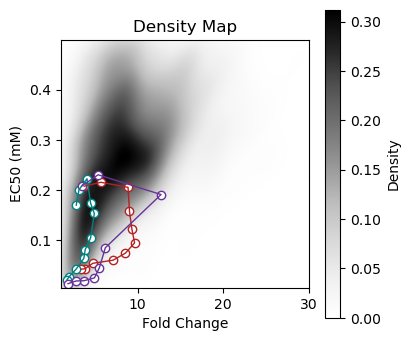

In [9]:
aspect_ratio = (max(x_data) - min(x_data)) / (max(y_data) - min(y_data))

x_f = [3.775536049, 5.738029823, 8.89255464, 9.062923636, 9.331463923, 9.657060548, 8.592063194, 7.157745642, 4.783113757, 3.86638491, 3.434058683]
y_f = [0.207191864, 0.214909876, 0.204843197, 0.156691624, 0.122537151, 0.093773839, 0.073330024, 0.059291503, 0.052988169, 0.042117741, 0.041176717]

x_t = [2.852118242, 3.171498333, 4.107685516, 4.525948858, 4.95912217, 4.525725973, 3.89962381, 3.73753348, 2.856420448, 2.028892584, 1.760337158]
y_t = [0.169233352, 0.200126116, 0.221901487, 0.173190479, 0.152672398, 0.103665414, 0.080387246, 0.062806304, 0.041749583, 0.026248969, 0.019806365]

x_b = [3.536886156, 5.403329721, 12.74421823, 6.245674344, 5.549545361, 4.977511875, 3.735759016, 2.847579144, 1.891802089]
y_b = [0.208006533, 0.229955214, 0.190465878, 0.084126421, 0.044132395, 0.023884028, 0.018106486, 0.017707452, 0.012281498]

# Create a density plot with adjusted aspect ratio
plt.figure(figsize=(4, 4))
plt.imshow(density, cmap='Greys', origin='lower', extent=[min(x_data), max(x_data), min(y_data), max(y_data)], aspect=aspect_ratio)
plt.colorbar(label='Density')  # Add color legend

# Overlay Remote Toehold
plt.plot(x_f,y_f, color='firebrick', linewidth=1)
plt.scatter(x_f, y_f, facecolors='white', edgecolors='firebrick', marker='o', linewidth=1, label="n:1")
plt.plot(x_t,y_t, color='teal', linewidth=1)
plt.scatter(x_t, y_t, facecolors='white', edgecolors='teal', marker='o', linewidth=1, label='1:m')
plt.plot(x_b,y_b, color='rebeccapurple', linewidth=1)
plt.scatter(x_b, y_b, facecolors='white', edgecolors='rebeccapurple', marker='o', linewidth=1, label = 'n:m')
#plt.legend(title='Remote Toehold')
plt.xlabel('Fold Change')
plt.ylabel('EC50 (mM)')
plt.title('Density Map')
plt.savefig('Remote-Toehold-Overlay.svg')
plt.show()